In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from time import time
import random
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score as f1_score_rep
from sklearn.metrics import accuracy_score

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

2024-01-30 06:17:55.771354: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-30 06:17:55.921465: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 06:17:55.921585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 06:17:55.925095: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-30 06:17:55.947199: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-30 06:17:55.948497: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
x_test = np.load('/home/jovyan/MQTTset/x_test.npy')
x_train = np.load('/home/jovyan/MQTTset/x_train.npy')
x_val = np.load('/home/jovyan/MQTTset/x_val.npy')
y_test = np.load('/home/jovyan/MQTTset/y_test.npy')
y_train = np.load('/home/jovyan/MQTTset/y_train.npy')
y_val = np.load('/home/jovyan/MQTTset/y_val.npy')

In [4]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

input_shape = x_train.shape[1:]

num_classes = len(np.unique(y_train))

cnn_model = Sequential()
cnn_model.add(Conv1D(filters=20, kernel_size=4, strides=2, padding='valid', activation='relu', input_shape=input_shape))
cnn_model.add(MaxPooling1D())
cnn_model.add(Conv1D(filters=20, kernel_size=4, strides=2, padding='same', activation='relu'))
cnn_model.add(Conv1D(filters=3, kernel_size=2, strides=1, padding='same', activation='relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=100, activation='relu'))
cnn_model.add(Dense(units=num_classes, activation='softmax'))

opt = SGD(lr=0.01) 

cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
hist = cnn_model.fit(x_train, y_train, epochs=2, batch_size=64,
                     validation_data=(x_val, y_val), 
                     callbacks=[early_stopping])

test_loss, test_acc = cnn_model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

y_hat = cnn_model.predict(x_test)
y_hat = np.argmax(y_hat, axis=-1)

2024-01-30 06:18:02.235205: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/2
112318/112318 [==============================] - 495s 4ms/step - loss: 0.9289 - accuracy: 0.9863 - val_loss: 0.0829 - val_accuracy: 0.9863
Epoch 2/2
113262/113262 [==============================] - 224s 2ms/step - loss: 0.0828 - accuracy: 0.9863
Test accuracy: 0.9863007664680481
113262/113262 [==============================] - 202s 2ms/step


113262/113262 [==============================] - 200s 2ms/step
FPR: [0. 0. 0. 1. 0. 0.]
TPR: [0. 0. 0. 1. 0. 0.]
FNR: [1. 1. 1. 0. 1. 1.]
TNR: [1. 1. 1. 0. 1. 1.]
Precision: 0.16438346274447266
Accuracy: 0.9863007764668359
F1-score: 0.9794984054624876
AUC: 0.5000002757278631
FPR: 0.16666666666666666
tpr: 0.16666666666666666
fnr: 0.8333333333333334
tnr: 0.8333333333333334


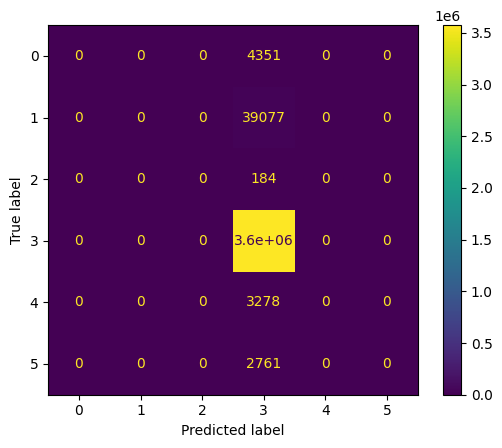

In [6]:
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, f1_score, roc_auc_score



conf_matrix = confusion_matrix(y_test, y_hat)
# tn, fp, fn, tp = conf_matrix.ravel()
cm = conf_matrix
fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)


fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
fnr = fn / (fn + tp)
tnr = tn / (tn + fp)
precision = precision_score(y_test, y_hat, average='macro')
accuracy = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average='weighted')
auc = roc_auc_score(y_test, cnn_model.predict(x_test), multi_class='ovr')

print(f"FPR: {fpr}")
print(f"TPR: {tpr}")
print(f"FNR: {fnr}")
print(f"TNR: {tnr}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"AUC: {auc}")

print(f"FPR: {np.mean(fpr)}")
print(f"tpr: {np.mean(tpr)}")
print(f"fnr: {np.mean(fnr)}")
print(f"tnr: {np.mean(tnr)}")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

import pandas as pd
metrics = {
    "model" : "cnn",
    "Accuracy": accuracy,
    "Precision": precision,
    "F1-score": f1,
    "FPR": np.mean(fpr),
    "TPR": np.mean(tpr),
    "FNR": np.mean(fnr),
    "TNR": np.mean(tnr),
    "AUC": auc
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("/home/jovyan/MQTTset/model.csv", mode='a', index=False)